In [1]:
import pandas as pd
import numpy as np

In [2]:
df_in = pd.read_csv('data/mhyph.txt', encoding = 'latin-1', header = None, names = ['words'])
df_in.head()

,words
0,a cap¥pel¥la
1,a for¥ti¥o¥ri
2,a go¥go
3,a pos¥te¥ri¥o¥ri
4,a pri¥o¥ri


In [3]:
# Remove all uppercase words, as they are abbreviations with no systematic hyphenation
df_in = df_in[df_in['words'] != df_in['words'].apply(lambda x: str(x).upper())]

In [4]:
def split_or_nan(x):
    import re
    try:
        return re.sub(r'¥ |\- |\/ ', '', 
               re.sub(r'¥$|\-$|\/$', '', 
               re.sub(r'[¥\-\/]+([\-\/])|([\-\/])[¥\-\/]+|(¥)¥+', r'\1', 
               re.sub(r'[^¥\-\/a-z ]', '',
               x.lower())))).split()
    except:
        return np.nan

In [5]:
df_in['lists'] = df_in['words'].apply(split_or_nan)
df_in.dropna(inplace = True)
df_in.head()

,words,lists
0,a cap¥pel¥la,"[a, cap¥pel¥la]"
1,a for¥ti¥o¥ri,"[a, for¥ti¥o¥ri]"
2,a go¥go,"[a, go¥go]"
3,a pos¥te¥ri¥o¥ri,"[a, pos¥te¥ri¥o¥ri]"
4,a pri¥o¥ri,"[a, pri¥o¥ri]"


In [6]:
vocab = list({word for l in df_in['lists'] for word in l})
vocab[86386]

'he¥mo¥glo¥bin¥ous'

In [7]:
def word2bits(word):
    import re
    import numpy as np
    idxs = [m.start() for m in re.finditer(r'[^a-z ].', word)]
    arr = np.zeros(len(word) - len(idxs), dtype = np.int32)
    arr[0] = 1
    for i, idx in enumerate(idxs):
        arr[idx - i] = 1
    bits = ''.join([str(i) for i in arr])
    return bits

def count_syls(word):
    import re
    return len(re.findall(r'[^a-z ]', word)) + 1

def clean_text(word):
    import re
    return re.sub(r'[^a-z ]', '', word)

In [8]:
print(f'{vocab[3]} --> {word2bits(vocab[3])}')

lim¥i¥na --> 100110


In [9]:
df_out = pd.DataFrame()
df_out['words'] = list(map(clean_text, vocab))
df_out['syl_seq'] = list(map(word2bits, vocab))
df_out['syls'] = list(map(count_syls, vocab))
df_out.head()

,words,syl_seq,syls
0,brigadiership,1000110001000,4
1,cauline,1001000,2
2,mousetrap,100001000,2
3,limina,100110,3
4,overlapping,11001001000,4


In [10]:
failed = [i for i in range(len(df_out)) if len(df_out['words'][i]) != len(df_out['syl_seq'][i])]
if failed:
    print('The following indices did not get counted correctly:')
    print(failed)
else:
    print('Words were correctly counted!')

Words were correctly counted!


In [11]:
df_out.to_csv('data/gutsyls.tsv', sep = '\t', encoding = 'utf-8', index = None)

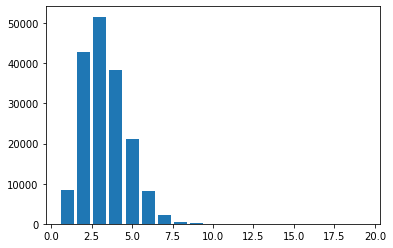

In [13]:
import matplotlib.pyplot as plt
counts = df_out['syls'].value_counts().sort_index()
fig, ax = plt.subplots()
ax.bar(counts.index, counts.values)
plt.show()